9673
['0.0', '0.0', '0.0', '0.0', '0.0']
0.0: 48
0.1: 13
0.2: 91
0.3: 205
0.4: 243
0.5: 615
0.6: 395
0.7: 716
0.8: 1910
0.9: 4175
1.0: 1262


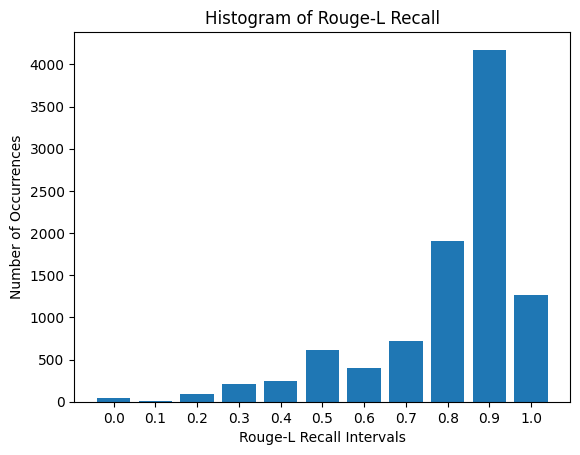

['0.0', '0.0', '0.0', '0.0', '0.0']
0.0: 48
0.1: 7
0.2: 58
0.3: 118
0.4: 149
0.5: 421
0.6: 538
0.7: 885
0.8: 2145
0.9: 4242
1.0: 1062


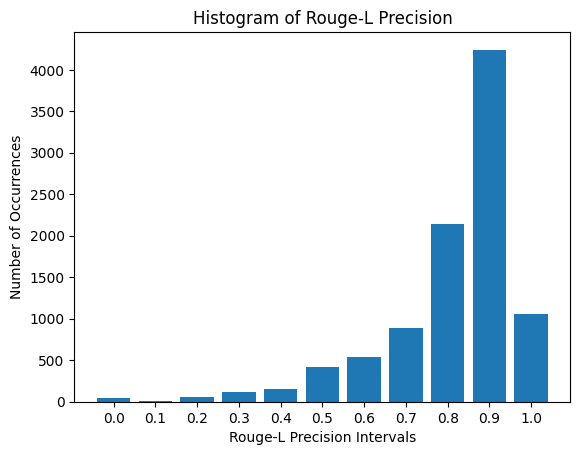

['0.0', '0.0', '0.0', '0.0', '0.0']
0.0: 48
0.1: 6
0.2: 54
0.3: 139
0.4: 221
0.5: 381
0.6: 687
0.7: 1216
0.8: 1851
0.9: 4510
1.0: 560


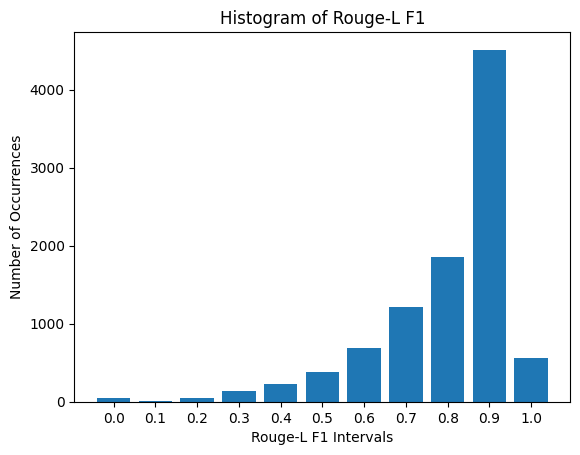

['0.0', '0.0', '0.0', '0.0', '0.0']
0.0: 3946
0.1: 3660
0.2: 1448
0.3: 465
0.4: 98
0.5: 26
0.6: 12
0.7: 13
0.8: 5


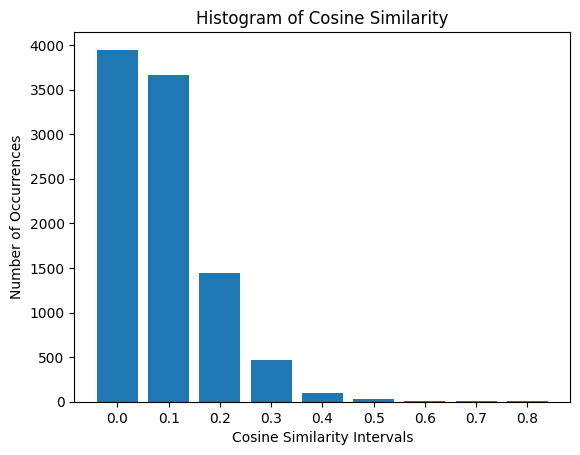

In [22]:
import math
from decimal import Decimal

from algo import calc_rouge_l, cal_cosine_similarity

import json
from collections import Counter
import matplotlib.pyplot as plt
import jsonlines

path = '../data/raw/test.jsonl'

# Replace 'your_metric_function' with your actual function to calculate the metric
def calculate_rouge(src_desc, dst_desc):
    return calc_rouge_l([dst_desc], src_desc)[0]
    

metrics = []

line_cnt = 0
with jsonlines.open(path) as reader:
    for parsed in reader:
        line_cnt += 1
        old_method = parsed['src_method']
        new_method = parsed['dst_method']
        src_desc = parsed['src_desc']
        dst_desc = parsed['dst_desc']
        # Calculate the metric and append to the list
        rouge_l = calculate_rouge(src_desc, dst_desc)
        similarity = cal_cosine_similarity(dst_desc, new_method)
        metrics.append({**rouge_l, 'cs': similarity})

print(line_cnt)

for m_key, m_name, m_preserve in (
        ('recall', 'Rouge-L Recall', 1),
        ('precision', 'Rouge-L Precision', 1),
        ('f1', 'Rouge-L F1', 1),
        ('cs', 'Cosine Similarity', 1)):
    # Count the occurrences of each metric interval
    metric_intervals = [str(round(metric[m_key], m_preserve)) for metric in metrics]  
    print(sorted(metric_intervals)[:5])
    counts = Counter(metric_intervals)
    counts = dict(sorted(counts.items(), key=lambda item: item[0]))
    
    for key, value in counts.items():
        print(f'{key}: {value}')

    # Plotting the histogram
    plt.bar(counts.keys(), counts.values())
    plt.xlabel(f'{m_name} Intervals')
    plt.ylabel('Number of Occurrences')
    plt.title(f'Histogram of {m_name}')
    plt.show()
